### Game Of Life - Erste Auswertung von frühen Messdaten

In [2]:
# =========================
#
# Titel : HPC Game Of Life
# Author: Dimitri Dening
# Date  : 29.06.2021
#
# =========================

import os
import os.path
import json
import shutil
import contextlib
import numpy as np
import matplotlib.pyplot as plt

### Auswertung Shared Memory

In [5]:
data_dir = '../rawdata//_old_data/shared-memory/dataset-1/dataset-1-1'
files = [filename for filename in os.listdir(data_dir) if filename.startswith('shrd_')]
file_accumulate = data_dir + '/accumulated_shrd.txt'

with contextlib.suppress(FileNotFoundError):
    os.remove(file_accumulate)
    
f_shrd = open(file_accumulate, "w")
f_shrd.write("[\n")
for postfix in files:
    file_dir = data_dir + "\\" + postfix
    current_file = open(file_dir)
    txt = current_file.read()
    f_shrd.write(txt + ",\n")
    current_file.close()
f_shrd.write("{\"eof\" : 1}\n]\n")
f_shrd.close()

In [6]:
# reading the data from the file
with open(file_accumulate) as f:
    data = f.read()
      
# reconstructing the data as a dictionary
js = json.loads(data)

x_shrd_threads = []
y_shrd_time = []

for data in js:
    x_shrd_threads.append(data.get("threads"))
    y_shrd_time.append(data.get("time"))

### Auswertung Distributed Memory

In [8]:
data_dir = '../rawdata/_old_data/distributed-memory/dataset-1/dataset-1-1'
files = [filename for filename in os.listdir(data_dir) if filename.startswith('distr_')]
file_accumulate = data_dir + '/accumulated_dstrb.txt'

with contextlib.suppress(FileNotFoundError):
    os.remove(file_accumulate)
    
f_dstrb = open(file_accumulate, "w")
f_dstrb.write("[\n")
for postfix in files:
    file_dir = data_dir + "\\" + postfix
    current_file = open(file_dir)
    txt = current_file.read()
    f_dstrb.write(txt + ",\n")
    current_file.close()
f_dstrb.write("{\"eof\" : 1}\n]\n")
f_dstrb.close()

In [9]:
# reading the data from the file
with open(file_accumulate) as f:
    data = f.read()
      
# reconstructing the data as a dictionary
js = json.loads(data)

# print(js)

x_dstr_threads = []
y_dstr_time = []

for data in js:
    x_dstr_threads.append(data.get("threads"))
    y_dstr_time.append(data.get("time"))

### Ergebnisse plotten

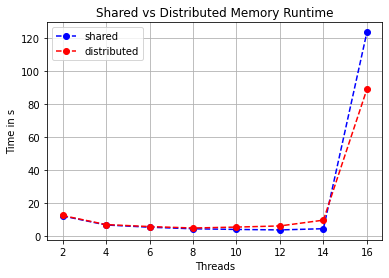

In [10]:
plt.title("Shared vs Distributed Memory Runtime")
plt.xlabel("Threads")
plt.ylabel("Time in s")
plt.plot(x_shrd_threads, y_shrd_time, "bo--", label="shared")
plt.plot(x_dstr_threads, y_dstr_time, "ro--", label="distributed")
plt.legend(loc="best")
plt.grid()
plt.savefig('shared-vs-dstr.png')
plt.show()

### Plot ohne Thread 16

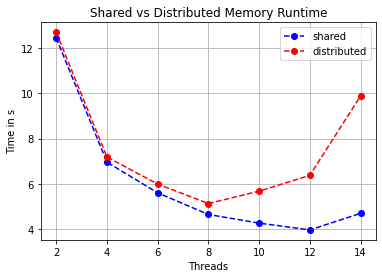

In [11]:
plt.title("Shared vs Distributed Memory Runtime")
plt.xlabel("Threads")
plt.ylabel("Time in s")
plt.plot(x_shrd_threads[:-2], y_shrd_time[:-2], "bo--", label="shared")
plt.plot(x_dstr_threads[:-2], y_dstr_time[:-2], "ro--", label="distributed")
plt.legend(loc="best")
plt.grid()
plt.savefig('shared-vs-dstr-no-16.png')
plt.show()

### Auswertung Datasets Distributed Memory

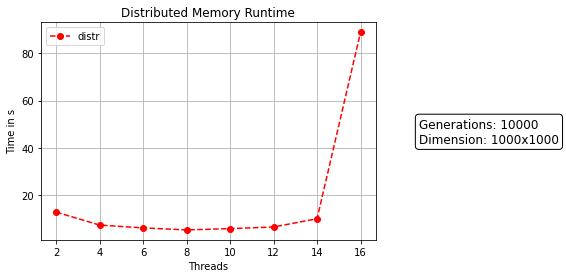

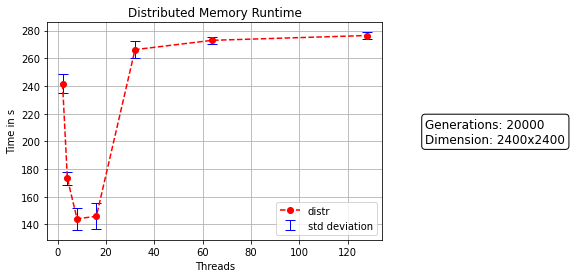

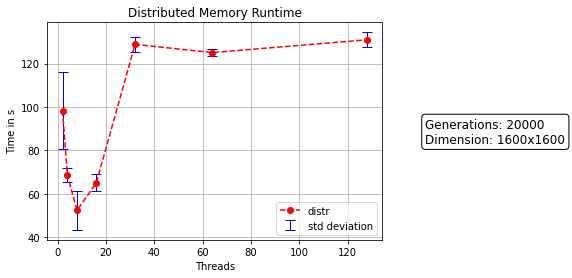

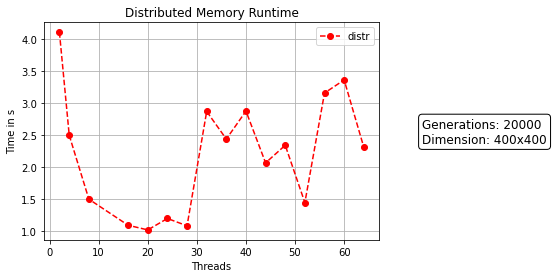

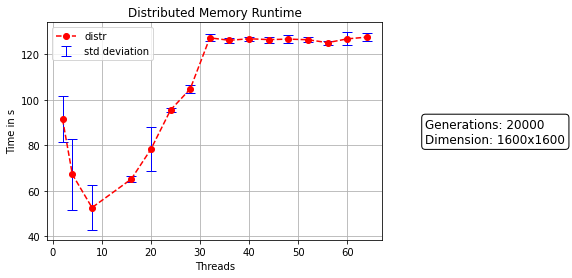

In [13]:
data_dir = '../rawdata/_old_data/distributed-memory/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

for index, data_set in enumerate(data_sets):

    x_data = []
    y_data = []
    
    sub_data_sets = [folder.path for folder in os.scandir(data_set) if folder.is_dir()]
    
    for sub_data_set in sub_data_sets:
        files = [filename for filename in os.listdir(sub_data_set) if filename.startswith('distr_')]
        file_accumulate = sub_data_set + '/accumulated_dstrb.txt'
    
        with contextlib.suppress(FileNotFoundError):
            os.remove(file_accumulate)
            
        f_dstrb = open(file_accumulate, "w")
        f_dstrb.write("[\n")
        for postfix in files:
            file_dir = sub_data_set + "\\" + postfix
            current_file = open(file_dir)
            txt = current_file.read()
            f_dstrb.write(txt + ",\n")
            current_file.close()
        f_dstrb.write("{\"eof\" : 1}\n]\n")
        f_dstrb.close() 

        # reading the data from the file
        with open(file_accumulate) as f:
            data = f.read()
      
        # reconstructing the data as a dictionary
        js = json.loads(data)

        x_dstr_threads = []
        y_dstr_time    = []
        method         = []
        field_size     = []
        frames         = []

        for data in js:
            if not data.get("eof"):
                x_dstr_threads.append(data.get("threads"))
                y_dstr_time.append(data.get("time")) 
                method.append(data.get("method"))
                field_size.append(data.get("size"))
                frames.append(data.get("frames"))
          
        x_data.append(x_dstr_threads)
        y_data.append(y_dstr_time)
    
    # https://stackoverflow.com/questions/15819980/calculate-mean-across-dimension-in-a-2d-array
    y_std = [0] * len(y_data[0])
    if len(y_data) != 0:
        if len(y_data) > 1:
            y_std = np.std(np.array(y_data), axis=0, ddof=1)
        y_plot = np.mean(np.array(y_data), axis=0)
        x_plot = np.array(x_data[0])
    
    textstr = '\n'.join((
        r'Generations: %i' % frames[0],
        r'Dimension: %ix%i' % (field_size[0], field_size[0])))
    
    plt.figtext(1, 0.5, textstr, fontsize=12, ha="left", va="center",
                bbox=dict(boxstyle="round", edgecolor='black', facecolor='none',))
    
    if len(y_data) > 1:
        plt.errorbar(x_plot, y_plot, yerr=y_std, fmt=' ', color='red', ecolor='blue', elinewidth=1, capsize=5, label="std deviation")
    plt.plot(x_plot, y_plot, "ro--", label=method[0])
    plt.legend(loc="best")
    plt.title("Distributed Memory Runtime")
    plt.xlabel("Threads")
    plt.ylabel("Time in s")
    plt.grid()
    # plt.savefig('dstr-dataset-%s.png' % str(index), bbox_inches='tight')
    plt.show() 